In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

In [3]:
#Import cleaned dataset

trips_df = pd.read_parquet('../../data/rides/Taxi_Trips_Sampled_Cleaned.parquet')
trips_df.head()

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tips,Tolls,Extras,...,h3_07_Dropoff,h3_08_Pickup,h3_08_Dropoff,h3_09_Pickup,h3_09_Dropoff,Pickup Centroid,Dropoff Centroid,datetime,temp,Precip
0,2015-01-01 00:00:00,2015-01-01 00:15:00,600.0,2.40,17031071500,17031070700,8.85,2.0,0.0,0.0,...,872664c12ffffff,882664c115fffff,882664c121fffff,892664c114fffff,892664c1257ffff,POINT (-87.631717366 41.914616286),POINT (-87.673807238 41.929272532),2015-01-01,-7.0115,0
1,2015-01-01 00:30:00,2015-01-01 00:45:00,1140.0,3.50,17031050600,17031071500,12.05,0.0,0.0,1.0,...,872664c11ffffff,882664c165fffff,882664c115fffff,892664ca597ffff,892664c114fffff,POINT (-87.676182496 41.950545696),POINT (-87.631717366 41.914616286),2015-01-01,-7.0115,0
2,2015-01-01 00:15:00,2015-01-01 00:15:00,248.0,1.10,17031839100,17031280100,5.45,0.0,0.0,1.0,...,872664cadffffff,882664c1a9fffff,882664c1adfffff,892664c1a8bffff,892664c1adbffff,POINT (-87.632746489 41.880994471),POINT (-87.642808466 41.885300022),2015-01-01,-7.0115,0
3,2015-01-01 00:00:00,2015-01-01 00:00:00,540.0,0.17,17031080300,17031063301,7.25,6.0,0.0,1.0,...,872664c10ffffff,882664c13bfffff,882664c101fffff,892664c13afffff,892664c101bffff,POINT (-87.63576009 41.90749193),POINT (-87.643022804 41.934539716),2015-01-01,-7.0115,0
4,2015-01-01 00:30:00,2015-01-01 00:45:00,780.0,1.30,17031320100,17031081403,8.25,0.0,0.0,1.0,...,872664c1effffff,882664c1e3fffff,882664c1e3fffff,892664c1e2fffff,892664c1e33ffff,POINT (-87.620992913 41.884987192),POINT (-87.618868355 41.890922026),2015-01-01,-7.0115,0


In [4]:
#Simplify times to full hour
trips_df['start_time_hour'] = trips_df['Trip Start Timestamp'].dt.floor('1H')
trips_df['end_time_hour'] = trips_df['Trip End Timestamp'].dt.floor('1H')

#Calculation of started and finished trips per hour
trips_starting = (trips_df.groupby(["start_time_hour"]).size().to_frame("trips_starting"))
trips_ending = (trips_df.groupby(["end_time_hour"]).size().to_frame("trips_ending"))

#Combine DFs and fill empty values
trips_hourly = pd.concat([trips_starting, trips_ending, ], axis=1)
trips_hourly = trips_hourly.fillna(0)

#Calculate difference of trips
trips_hourly['trips_diff'] = trips_hourly['trips_starting'] - trips_hourly['trips_ending']
trips_hourly['trips_active'] = trips_hourly['trips_diff'].cumsum()
trips_hourly['trips_prev_active'] = trips_hourly['trips_active'].shift(1)

trips_hourly = trips_hourly[['trips_starting', 'trips_prev_active']]

trips_hourly = trips_hourly.dropna()

trips_hourly["ongoing_trips"] = trips_hourly["trips_starting"] + trips_hourly["trips_prev_active"]

trips_hourly['day_of_year'] = trips_hourly.index.day_of_year
trips_hourly['hour'] = trips_hourly.index.hour
trips_hourly['day_of_week'] = trips_hourly.index.day_of_week

trips_hourly


,trips_starting,trips_prev_active,ongoing_trips,day_of_year,hour,day_of_week
2015-01-01 01:00:00,70.0,8.0,78.0,1,1,3
2015-01-01 02:00:00,91.0,22.0,113.0,1,2,3
2015-01-01 03:00:00,57.0,18.0,75.0,1,3,3
2015-01-01 04:00:00,17.0,6.0,23.0,1,4,3
2015-01-01 05:00:00,3.0,1.0,4.0,1,5,3
...,...,...,...,...,...,...
2015-12-31 08:00:00,8.0,2.0,10.0,365,8,3
2015-12-31 09:00:00,8.0,3.0,11.0,365,9,3
2015-12-31 10:00:00,8.0,2.0,10.0,365,10,3
2015-12-31 11:00:00,15.0,0.0,15.0,365,11,3


In [5]:
# Create a copy of the 'trips_df' DataFrame and set the floored datetime as the index
trips_df_copy = trips_df.copy()
trips_df_copy.set_index(trips_df_copy['Trip Start Timestamp'].dt.floor('H'), inplace=True)

precip_columns = ['Precip']
precip_data = trips_df_copy[precip_columns]

# Merge 'precip_data' into 'trips_hourly' based on the datetime index
trips_hourly_with_precip = trips_hourly.merge(precip_data, left_index=True, right_index=True, how='left')

trips_hourly_with_precip

,trips_starting,trips_prev_active,ongoing_trips,day_of_year,hour,day_of_week,Precip
2015-01-01 01:00:00,70.0,8.0,78.0,1,1,3,0.0
2015-01-01 01:00:00,70.0,8.0,78.0,1,1,3,0.0
2015-01-01 01:00:00,70.0,8.0,78.0,1,1,3,0.0
2015-01-01 01:00:00,70.0,8.0,78.0,1,1,3,0.0
2015-01-01 01:00:00,70.0,8.0,78.0,1,1,3,0.0
...,...,...,...,...,...,...,...
2015-12-31 11:00:00,15.0,0.0,15.0,365,11,3,0.0
2015-12-31 11:00:00,15.0,0.0,15.0,365,11,3,0.0
2015-12-31 11:00:00,15.0,0.0,15.0,365,11,3,0.0
2015-12-31 12:00:00,2.0,3.0,5.0,365,12,3,0.0


In [6]:
#trips_df['trips_month']=trips_df.groupby['month_start'].sum()
trips_per_month = trips_df.groupby('month_start').size().reset_index(name='total_trips')
trips_per_month


,month_start,total_trips
0,1,13982
1,2,14385
2,3,16100
3,4,14942
4,5,16486
5,6,15479
6,7,14075
7,8,13726
8,9,13491
9,10,14496


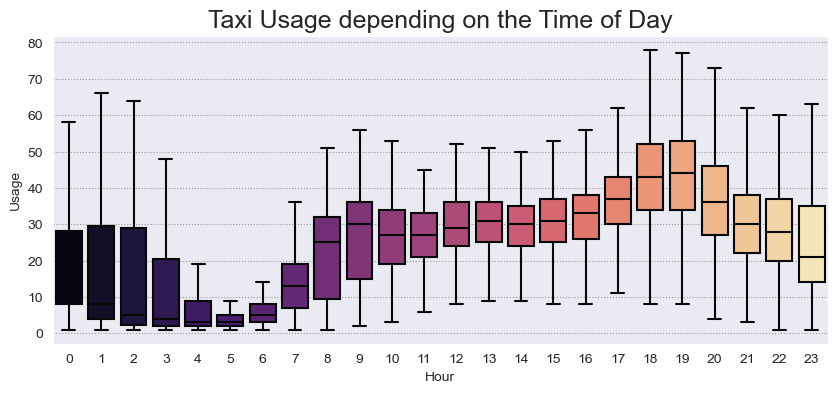

In [22]:
########### Why is the usage scale small? #####################
trips_hourly_hour = trips_hourly.groupby(["day_of_year","hour"])["ongoing_trips"].sum()
trips_hourly_hour = pd.DataFrame(trips_hourly_hour)

#Displaying values graphically
fig,ax = plt.subplots(figsize=(10,4))
sns.boxplot(x=trips_hourly_hour.index.get_level_values(1), y=trips_hourly_hour["ongoing_trips"],ax=ax, palette="magma", showfliers=False)
ax.set_title("Taxi Usage depending on the Time of Day", fontsize=18, fontname="Arial")
ax.set_xlabel("Hour")
ax.set_ylabel("Usage")
plt.show()

In [23]:
################# Why is number of ongoing trips higher than the size of our datadrame (171339)? ###############
print(trips_hourly_hour['ongoing_trips'].sum())
trips_hourly_hour

hour_1_data = trips_hourly_hour[trips_hourly_hour.index.get_level_values('hour') == 1]

sum_ongoing_trips_hour_1 = hour_1_data['ongoing_trips'].sum()

print("Total ongoing trips for hour==1:", sum_ongoing_trips_hour_1)

211891.0
Total ongoing trips for hour==1: 5983.0


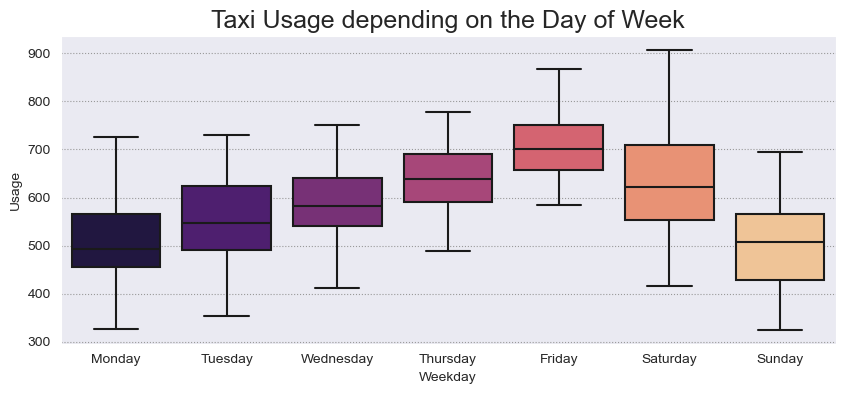

In [24]:
weekday=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
trips_hourly_week = trips_hourly.groupby(["day_of_year","day_of_week"])["ongoing_trips"].sum()
trips_hourly_week = pd.DataFrame(trips_hourly_week)

#Displaying values graphically
fig,ax = plt.subplots(figsize=(10,4))
sns.boxplot(x=trips_hourly_week.index.get_level_values(1), y=trips_hourly_week["ongoing_trips"],ax=ax, palette="magma", showfliers=False)
ax.set_title("Taxi Usage depending on the Day of Week", fontsize=18, fontname="Arial")
ax.set_xlabel("Weekday")
ax.set_ylabel("Usage")
ax.set_xticklabels(weekday)
plt.show()

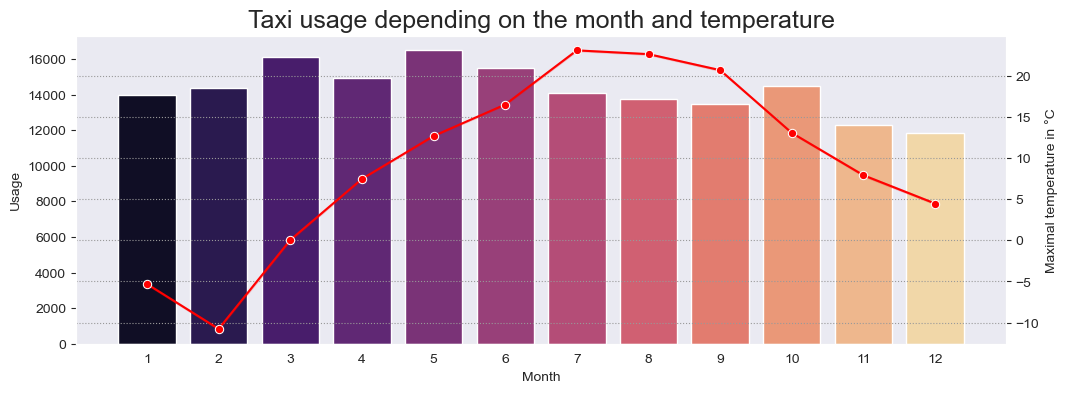

In [10]:
fig,ax = plt.subplots(figsize=(12,4)) 
sns.barplot(data=trips_per_month, x="month_start", y="total_trips", palette="magma", ax=ax)
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax.set_title("Taxi usage depending on the month and temperature", fontsize=18, fontname="Arial")
ax.set_xlabel("Month")
ax.set_ylabel("Usage")

ax2 = ax.twinx()
# month start -1 to fit it to the taxi usage 
sns.lineplot(x=(trips_df["month_start"]-1), y=trips_df["temp"], ax=ax2, color='red', marker='o')
ax2.set_ylabel("Maximal temperature in °C")
ax.yaxis.grid(False)

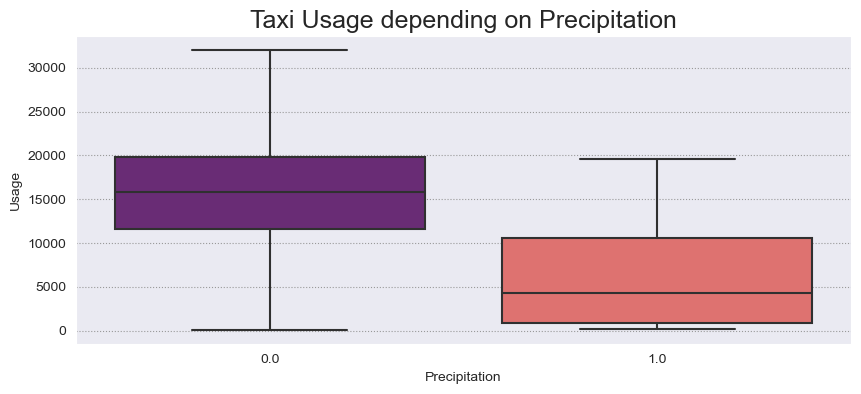

In [27]:

#group by precipitation and plot
trips_precip = trips_hourly_with_precip.groupby(["day_of_year","Precip"])["ongoing_trips"].sum()
trips_precip = pd.DataFrame(trips_precip)

fig,ax = plt.subplots(figsize=(10,4)) 

sns.boxplot(x=trips_precip.index.get_level_values(1), y=trips_precip["ongoing_trips"],ax=ax, palette="magma", showfliers=False)
ax.set_title("Taxi Usage depending on Precipitation", fontsize=18, fontname="Arial")
ax.set_xlabel("Precipitation")
ax.set_ylabel("Usage")

plt.show()